In [29]:
import pandas as pd
import requests

# Load your subway delay data
df = pd.read_csv(
    "MTA_Subway_Delay-Causing_Incidents__2020-2024_20250717 - MTA_Subway_Delay-Causing_Incidents__2020-2024_20250717.csv",
    parse_dates=["Month"],
)
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={"month": "date", "incidents": "incident_count"}, inplace=True)

# Extract unique dates to fetch weather for
dates = df["date"].dt.date.unique()
start_date = min(dates).isoformat()
end_date = max(dates).isoformat()

# NYC coordinates
lat, lon = 40.7128, -74.0060

# Fetch daily weather data from Open-Meteo
weather_url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={lat}&longitude={lon}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,"
    f"snowfall_sum,windspeed_10m_max"
    f"&timezone=America%2FNew_York"
    f"&temperature_unit=fahrenheit"
)

print("Fetching daily weather data from Open-Meteo...")
response = requests.get(weather_url)
weather_json = response.json()

weather = pd.DataFrame(weather_json["daily"])
weather["date"] = pd.to_datetime(weather["time"])
weather.drop(columns=["time"], inplace=True)

# --- Fetch monthly average humidity separately ---

# Generate all months in the date range
months = pd.date_range(start=start_date, end=end_date, freq="MS").strftime("%Y-%m-%d").tolist()
humidity_records = []

for month_start in months:
    month_end = (pd.to_datetime(month_start) + pd.offsets.MonthEnd()).strftime("%Y-%m-%d")
    humidity_url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}"
        f"&start_date={month_start}&end_date={month_end}"
        f"&hourly=relative_humidity_2m"
        f"&timezone=America/New_York"
    )
    r = requests.get(humidity_url)
    data = r.json()
    humidity_values = data.get("hourly", {}).get("relative_humidity_2m", [])
    if humidity_values:
        avg_humidity = sum(humidity_values) / len(humidity_values)
    else:
        avg_humidity = None
    humidity_records.append({"month": pd.to_datetime(month_start), "avg_humidity": avg_humidity})

humidity_df = pd.DataFrame(humidity_records)

# Merge daily weather with subway delay data on date
merged = pd.merge(df, weather, on="date", how="left")

# Add month column to merged for humidity merge
merged["month"] = merged["date"].dt.to_period("M").dt.to_timestamp()

# Merge monthly humidity on 'month'
merged = pd.merge(merged, humidity_df, on="month", how="left")

# Drop the helper 'month' column if you want
merged.drop(columns=["month"], inplace=True)

# Save or view the result
merged.to_csv("merged_subway_weather_with_humidity.csv", index=False)
print("✅ Merged data with humidity saved to 'merged_subway_weather_with_humidity.csv'")

Fetching daily weather data from Open-Meteo...
✅ Merged data with humidity saved to 'merged_subway_weather_with_humidity.csv'


In [41]:
merged

,date,division,line,day type,reporting category,subcategory,incident_count,temperature_2m_max,temperature_2m_min,precipitation_sum,snowfall_sum,windspeed_10m_max,avg_humidity
0,2024-12-01,A DIVISION,1,1,NaN,NaN,0,36.7,25.2,0.0,0.0,17.9,73.606183
1,2024-12-01,A DIVISION,1,1,Crew Availability,Crew Availability,16,36.7,25.2,0.0,0.0,17.9,73.606183
2,2024-12-01,A DIVISION,1,1,External Factors,External Agency or Utility,0,36.7,25.2,0.0,0.0,17.9,73.606183
3,2024-12-01,A DIVISION,1,1,External Factors,External Debris on Roadbed,2,36.7,25.2,0.0,0.0,17.9,73.606183
4,2024-12-01,A DIVISION,1,1,External Factors,Inclement Weather,0,36.7,25.2,0.0,0.0,17.9,73.606183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72112,2020-01-01,B DIVISION,S Rock,2,Planned ROW Work,Subways Maintenance,1,39.8,30.9,0.0,0.0,28.2,69.090054
72113,2020-01-01,B DIVISION,S Rock,2,Planned ROW Work,Work Equipment,0,39.8,30.9,0.0,0.0,28.2,69.090054
72114,2020-01-01,B DIVISION,S Rock,2,Police & Medical,Persons on Roadbed,0,39.8,30.9,0.0,0.0,28.2,69.090054
72115,2020-01-01,B DIVISION,S Rock,2,Police & Medical,"Public Conduct, Crime, Police Response",1,39.8,30.9,0.0,0.0,28.2,69.090054


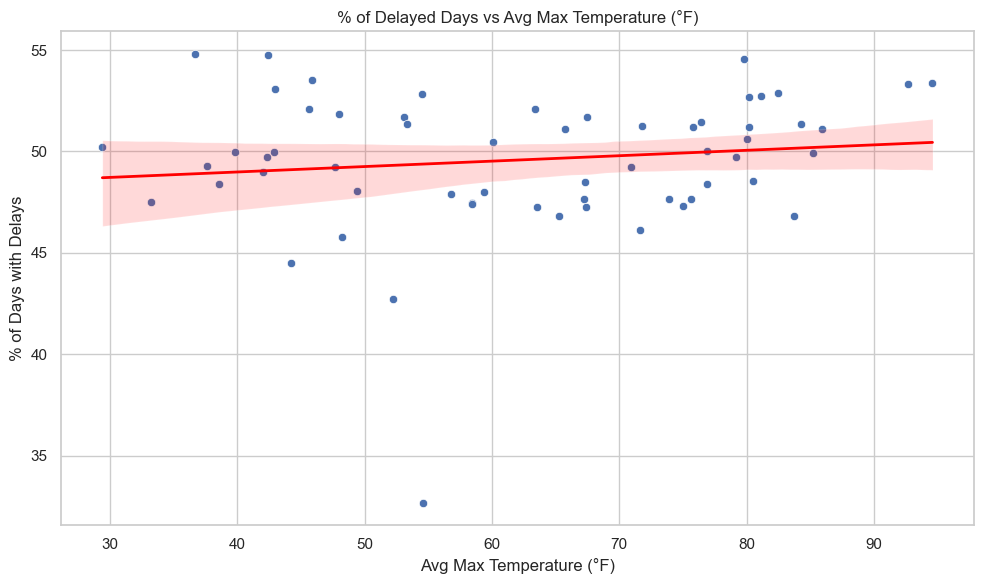

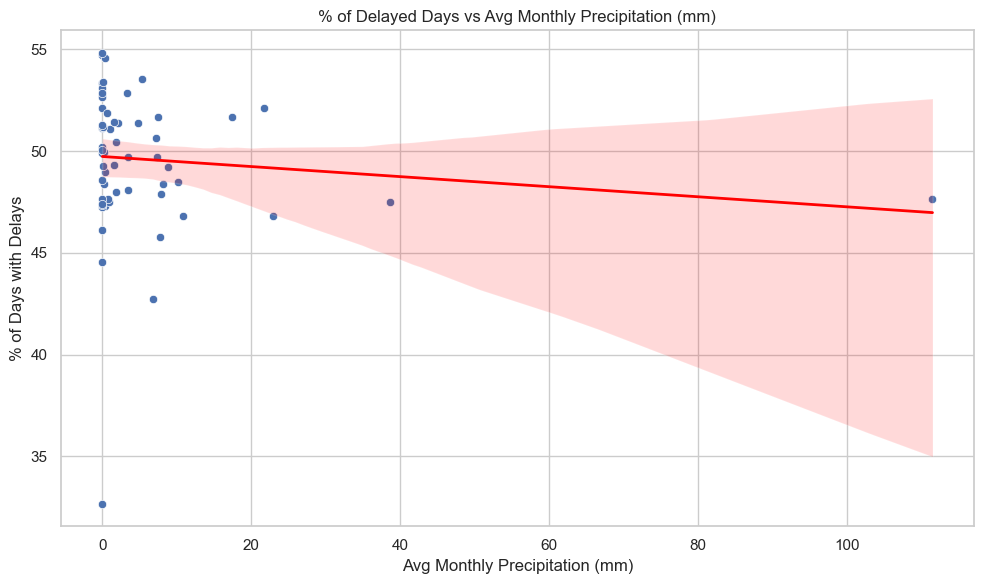

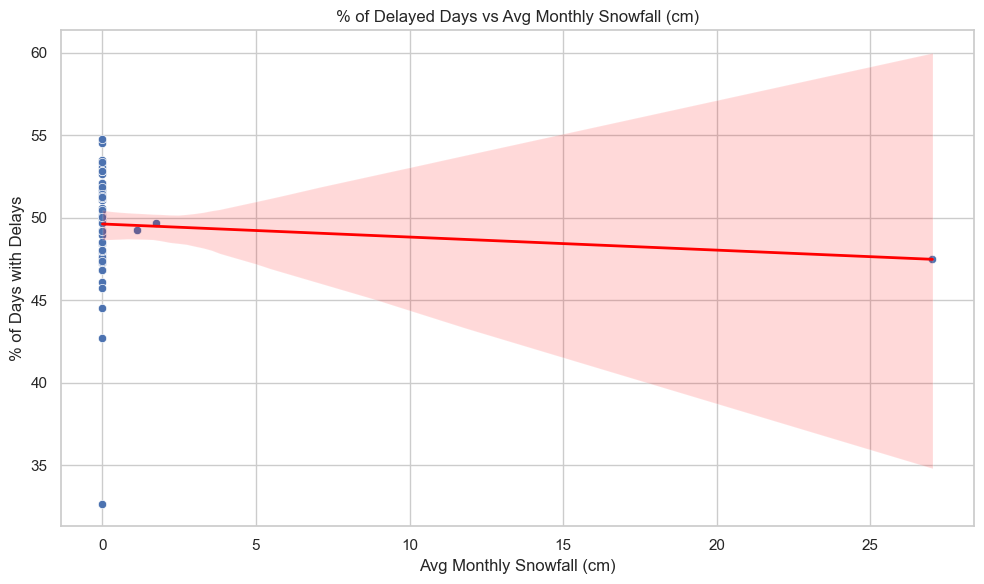

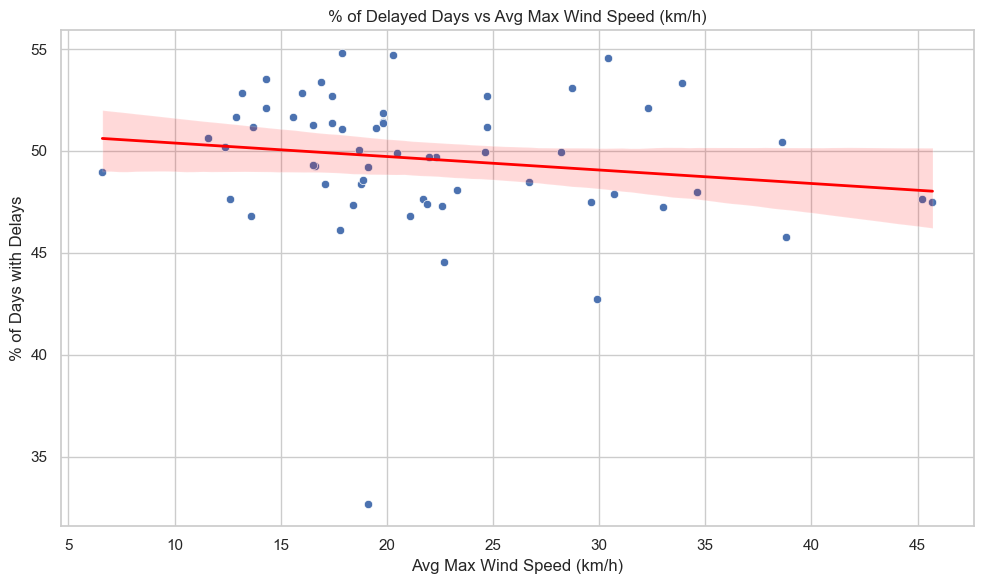

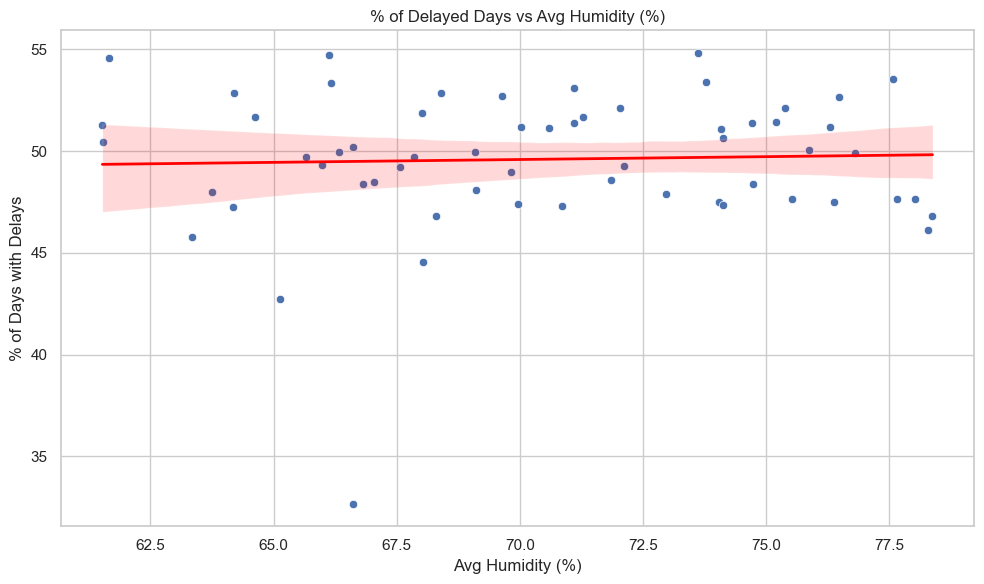

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load merged data
df = pd.read_csv("merged_subway_weather_with_humidity.csv", parse_dates=["date"])

# Step 1: Create a binary 'delayed' column for each day
df["delayed"] = df["incident_count"] > 0  # True if any incident occurred

# Step 2: Group by month to calculate delay rate (% of delayed days per month)
df["month_period"] = df["date"].dt.to_period("M")
monthly_delay_rate = (
    df.groupby("month_period")["delayed"]
    .mean()
    .reset_index()
    .rename(columns={"delayed": "delay_rate"})
)
monthly_delay_rate["delay_rate"] *= 100  # Convert to percentage

# Step 3: Group weather data monthly (average values per month)
monthly_weather = (
    df.groupby("month_period")[
        ["temperature_2m_max", "precipitation_sum", "snowfall_sum", "windspeed_10m_max", "avg_humidity"]
    ]
    .mean()
    .reset_index()
)

# Step 4: Merge delay rate with weather
monthly_merged = pd.merge(monthly_delay_rate, monthly_weather, on="month_period")

# Step 5: Visualization

sns.set(style="whitegrid")

def plot_weather_vs_delay(x, xlabel):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=monthly_merged, x=x, y="delay_rate")
    sns.regplot(data=monthly_merged, x=x, y="delay_rate", scatter=False, color="red", line_kws={"linewidth": 2})
    plt.title(f"% of Delayed Days vs {xlabel}")
    plt.xlabel(xlabel)
    plt.ylabel("% of Days with Delays")
    plt.tight_layout()
    plt.show()

# Temperature
plot_weather_vs_delay("temperature_2m_max", "Avg Max Temperature (°F)")

# Precipitation
plot_weather_vs_delay("precipitation_sum", "Avg Monthly Precipitation (mm)")

# Snowfall
plot_weather_vs_delay("snowfall_sum", "Avg Monthly Snowfall (cm)")

# Wind
plot_weather_vs_delay("windspeed_10m_max", "Avg Max Wind Speed (km/h)")

# Humidity
plot_weather_vs_delay("avg_humidity", "Avg Humidity (%)")


In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Select features and target
features = ["temperature_2m_max", "precipitation_sum", "snowfall_sum", "windspeed_10m_max", "avg_humidity"]
target = "delay_rate"

X = monthly_merged[features]
y = monthly_merged[target]

# Step 2: Train/test split (chronological order)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
# Step 3: Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

# Optional: show actual vs predicted This is only for the test data
comparison = pd.DataFrame({
    "Month": monthly_merged.loc[X_test.index, "month_period"].astype(str),
    "Actual % Delayed Days": np.round(y_test.values, 2),
    "Predicted % Delayed Days": np.round(y_pred, 2),
    "Difference:": np.round(abs(y_test.values - y_pred), 2)
})
comparison

MAE: 3.9
RMSE: 4.21


,Month,Actual % Delayed Days,Predicted % Delayed Days,Difference:
48,2024-01,52.10,48.82,3.28
49,2024-02,51.85,48.39,3.46
50,2024-03,54.73,48.10,6.63
51,2024-04,52.84,48.58,4.26
52,2024-05,51.44,49.63,1.81
53,2024-06,52.86,48.66,4.21
54,2024-07,51.19,49.13,2.06
55,2024-08,53.37,49.85,3.52
56,2024-09,51.36,49.31,2.05
57,2024-10,51.28,48.18,3.09


In [58]:
model = LinearRegression()
model.fit(X, y)
y_pred_all = model.predict(X)

comparison_all = pd.DataFrame({
    "Month": monthly_merged["month_period"].astype(str),
    "Actual % Delayed Days": np.round(y.values, 2),
    "Predicted % Delayed Days": np.round(y_pred_all, 2),
    "Difference": np.round(abs(y.values - y_pred_all), 2)
})
comparison_all

,Month,Actual % Delayed Days,Predicted % Delayed Days,Difference
0,2020-01,49.96,48.69,1.27
1,2020-02,48.97,49.97,1.00
2,2020-03,44.53,49.13,4.60
3,2020-04,32.69,49.63,16.95
4,2020-05,46.83,49.66,2.84
5,2020-06,47.29,49.74,2.45
6,2020-07,50.62,50.60,0.02
7,2020-08,49.92,50.29,0.37
8,2020-09,48.40,50.18,1.78
9,2020-10,46.13,50.06,3.93
